In [ ]:
# OUTLINE

# many columns with small number of Y/N, rest missing: for categorical, make category for missing
# - possible thoughts: outcome by "assigned by" (aka who called it in); outcome by race, gang affiliation, etc

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn import preprocessing, metrics, ensemble
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
df_clean = pd.read_csv('ISR_data_clean.csv',low_memory=False)
df_clean.head()

,CONTACT_CARD_ID,CONTACT_TYPE_CD,CARD_NO,CONTACT_DATE,CONTACT_HOUR,SUBMITTING_BEAT_CD,JUVENILE_I,CLOTHING_DESCR,NAME_VERIFIED_I,RD_NO,...,STOLEN_PROPERTY_I,SEARCH_PROPERTY_I,S_ALCOHOL_I,S_PARA_I,S_STOLEN_PROPERTY_I,GANG_OTHER,OTHER_DESCR,S_OTHER_I,S_OTHER_DESCR,NAME
0,20410357,INVSTG,ISR000410357,01-JAN-2018 00:08,0,2523,N,"BROWN JACKET, JEANS",NaN,JB100012,...,NaN,N,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN
1,20410350,INVSTG,ISR000410350,01-JAN-2018 00:08,0,2523,N,BLUE JEANS AND A BLACK SWEATER,NaN,JB100012,...,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20410351,INVSTG,ISR000410351,01-JAN-2018 00:08,0,2523,N,"GRAY HOODED SWEATER, JEANS",NaN,JB100012,...,NaN,N,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN
3,20410338,INVSTG,ISR000410338,01-JAN-2018 00:10,0,6738,N,"BLACK LONGSLEEVE SHIRT, GREY JEANS",Y,NaN,...,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ORCHESTRA ALBANY
4,20410352,INVSTG,ISR000410352,01-JAN-2018 00:30,0,0767,N,"WHITE SOX HAT, BLACK JACKET, BLACK JEANS",Y,NaN,...,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# exploring further from our EDA

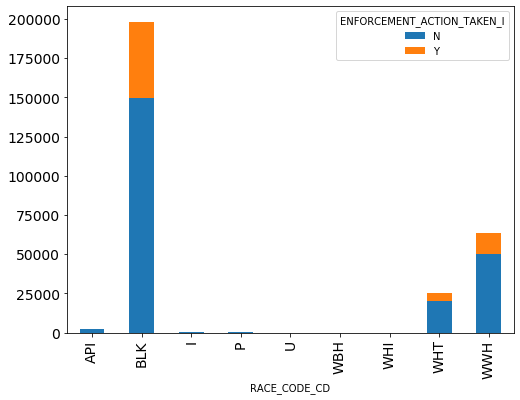

In [3]:
df_clean.groupby(["RACE_CODE_CD","ENFORCEMENT_ACTION_TAKEN_I"]).size().unstack().plot(kind='bar', stacked=True, figsize=(8,6),fontsize=14) 

# add percentages to this
# compare numbers below (and percenages overall) to demographics of Chicago

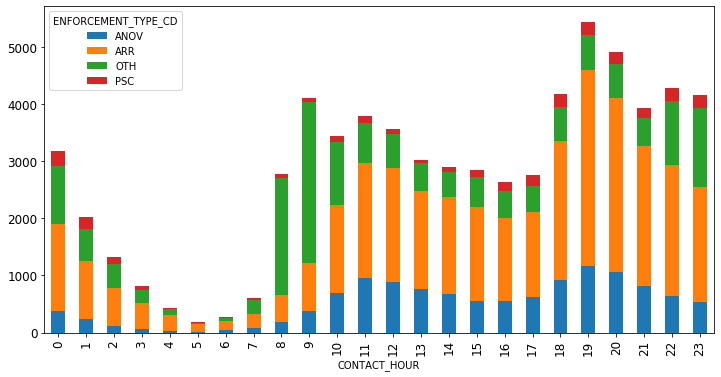

In [4]:
df_clean.groupby(["CONTACT_HOUR","ENFORCEMENT_TYPE_CD"]).size().unstack().plot(kind='bar', stacked=True, figsize=(12,6),fontsize=12)

In [5]:
# next, limit this to arrests only

arrests_only = df_clean.loc[df_clean["ENFORCEMENT_TYPE_CD"] == "ARR"]
arrests_only.head()

,CONTACT_CARD_ID,CONTACT_TYPE_CD,CARD_NO,CONTACT_DATE,CONTACT_HOUR,SUBMITTING_BEAT_CD,JUVENILE_I,CLOTHING_DESCR,NAME_VERIFIED_I,RD_NO,...,STOLEN_PROPERTY_I,SEARCH_PROPERTY_I,S_ALCOHOL_I,S_PARA_I,S_STOLEN_PROPERTY_I,GANG_OTHER,OTHER_DESCR,S_OTHER_I,S_OTHER_DESCR,NAME
8,20410600,INVSTG,ISR000410600,01-JAN-2018 00:35,0,1461,N,GRAY SWEATER,NaN,JA100059,...,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,20410598,INVSTG,ISR000410598,01-JAN-2018 00:35,0,1461,N,WHITE SHIRT,NaN,JB100059,...,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,20410597,INVSTG,ISR000410597,01-JAN-2018 00:38,0,1461,N,BLACK AND GRAY HOODED SWEATER,NaN,JB100059,...,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,20410354,INVSTG,ISR000410354,01-JAN-2018 00:52,0,913R,N,BLACK JACKET / BLACK AND BLUE JOGGING PANTS,NaN,JB100070,...,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,20410382,INVSTG,ISR000410382,01-JAN-2018 01:05,1,6717,N,"RED HOODY, BLUE JEANS",NaN,NaN,...,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GANGSTER DISCIPLES


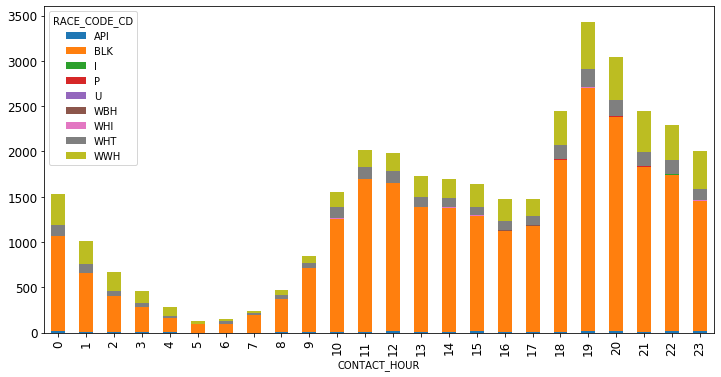

In [6]:
arrests_only.groupby(["CONTACT_HOUR","RACE_CODE_CD"]).size().unstack().plot(kind='bar', stacked=True, figsize=(12,6),fontsize=12)
# this is a combo of the previous charts
# arrests only (so action taken is also Y), looking at race and hour

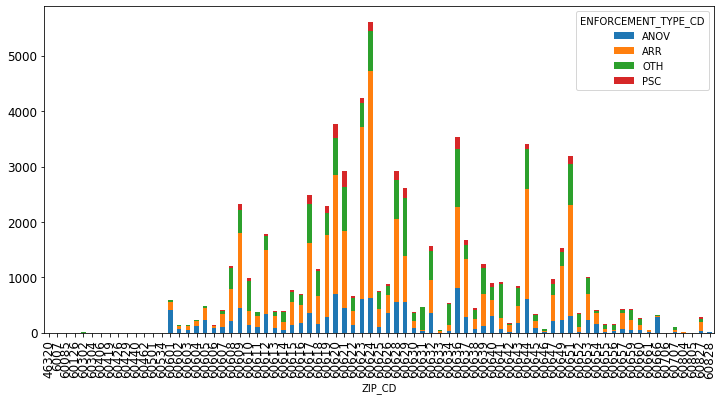

In [7]:
df_clean.groupby(["ZIP_CD","ENFORCEMENT_TYPE_CD"]).size().unstack().plot(kind='bar', stacked=True, figsize=(12,6),fontsize=12)

In [ ]:
# create basic model using these three columns
# how accurate can we get (arrest or not) using only race, zipcode and contact hour?

In [8]:
first_model = df_clean[["ZIP_CD","ENFORCEMENT_TYPE_CD","CONTACT_HOUR", "RACE_CODE_CD"]]
first_model.head()

,ZIP_CD,ENFORCEMENT_TYPE_CD,CONTACT_HOUR,RACE_CODE_CD
0,60641,NaN,0,WWH
1,60641,NaN,0,WWH
2,60641,NaN,0,WWH
3,60634,NaN,0,WWH
4,60621,NaN,0,BLK


In [ ]:
# remove rows with missing zipcode
# change enforcement_type_cd to binary
# missing, anything but arr = 0?

In [9]:
first_model.dropna(subset = ["ZIP_CD"], axis=0, inplace=True)
first_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289734 entries, 0 to 290144
Data columns (total 4 columns):
ZIP_CD                 289734 non-null object
ENFORCEMENT_TYPE_CD    67459 non-null object
CONTACT_HOUR           289734 non-null int64
RACE_CODE_CD           289734 non-null object
dtypes: int64(1), object(3)
memory usage: 11.1+ MB


/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
# we have 67k lines with enforcement type - plenty to go off of!

first_model.dropna(subset = ["ENFORCEMENT_TYPE_CD"], axis=0, inplace=True)
first_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67459 entries, 8 to 290144
Data columns (total 4 columns):
ZIP_CD                 67459 non-null object
ENFORCEMENT_TYPE_CD    67459 non-null object
CONTACT_HOUR           67459 non-null int64
RACE_CODE_CD           67459 non-null object
dtypes: int64(1), object(3)
memory usage: 2.6+ MB


/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
# re-setting our axis

first_model.reset_index(drop=True, inplace=True)
first_model.head()

,ZIP_CD,ENFORCEMENT_TYPE_CD,CONTACT_HOUR,RACE_CODE_CD
0,60647,ARR,0,BLK
1,60647,ARR,0,BLK
2,60647,ARR,0,BLK
3,60610,OTH,0,WWH
4,60610,OTH,0,BLK


In [12]:
# now, create a target column

first_model['TARGET'] = np.where(first_model['ENFORCEMENT_TYPE_CD'] == 'ARR', 1, 0)
first_model.head()

/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ZIP_CD,ENFORCEMENT_TYPE_CD,CONTACT_HOUR,RACE_CODE_CD,TARGET
0,60647,ARR,0,BLK,1
1,60647,ARR,0,BLK,1
2,60647,ARR,0,BLK,1
3,60610,OTH,0,WWH,0
4,60610,OTH,0,BLK,0


In [13]:
# we're going to drop the enforcement type column now
# since this informed our target, we'll need to remove that from our model or risk leakage

first_model.drop(columns = ["ENFORCEMENT_TYPE_CD"], axis=0, inplace=True)
first_model.head()

/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,ZIP_CD,CONTACT_HOUR,RACE_CODE_CD,TARGET
0,60647,0,BLK,1
1,60647,0,BLK,1
2,60647,0,BLK,1
3,60610,0,WWH,0
4,60610,0,BLK,0


In [14]:
y = first_model['TARGET']

In [15]:
first_model_data = first_model.drop(["TARGET"], axis = 1)
first_model_data.head()

,ZIP_CD,CONTACT_HOUR,RACE_CODE_CD
0,60647,0,BLK
1,60647,0,BLK
2,60647,0,BLK
3,60610,0,WWH
4,60610,0,BLK


In [ ]:
# move on to the model

In [16]:
first_model.isna().sum()

ZIP_CD          0
CONTACT_HOUR    0
RACE_CODE_CD    0
TARGET          0
dtype: int64

In [17]:
# zip code, race code need to be one-hot encoded
# (zip code is technically a number, but should be treated categorically)

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)
first_model_data.head()

,ZIP_CD,CONTACT_HOUR,RACE_CODE_CD
0,60647,0,BLK
1,60647,0,BLK
2,60647,0,BLK
3,60610,0,WWH
4,60610,0,BLK


In [18]:
first_model_data['RACE_CODE_CD'] = label_encoder.fit_transform(first_model_data['RACE_CODE_CD'])
first_model_data.head()

,ZIP_CD,CONTACT_HOUR,RACE_CODE_CD
0,60647,0,1
1,60647,0,1
2,60647,0,1
3,60610,0,8
4,60610,0,1


In [19]:
first_model_data = pd.get_dummies(first_model_data, columns=['RACE_CODE_CD'])
first_model_data.head()

,ZIP_CD,CONTACT_HOUR,RACE_CODE_CD_0,RACE_CODE_CD_1,RACE_CODE_CD_2,RACE_CODE_CD_3,RACE_CODE_CD_4,RACE_CODE_CD_5,RACE_CODE_CD_6,RACE_CODE_CD_7,RACE_CODE_CD_8
0,60647,0,0,1,0,0,0,0,0,0,0
1,60647,0,0,1,0,0,0,0,0,0,0
2,60647,0,0,1,0,0,0,0,0,0,0
3,60610,0,0,0,0,0,0,0,0,0,1
4,60610,0,0,1,0,0,0,0,0,0,0


In [20]:
# and we'll repeat that with zipcode now

first_model_data['ZIP_CD'] = label_encoder.fit_transform(first_model_data['ZIP_CD'])
first_model_data = pd.get_dummies(first_model_data, columns=['ZIP_CD'])
first_model_data.head()

,CONTACT_HOUR,RACE_CODE_CD_0,RACE_CODE_CD_1,RACE_CODE_CD_2,RACE_CODE_CD_3,RACE_CODE_CD_4,RACE_CODE_CD_5,RACE_CODE_CD_6,RACE_CODE_CD_7,RACE_CODE_CD_8,...,ZIP_CD_67,ZIP_CD_68,ZIP_CD_69,ZIP_CD_70,ZIP_CD_71,ZIP_CD_72,ZIP_CD_73,ZIP_CD_74,ZIP_CD_75,ZIP_CD_76
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
X_train, X_test, y_train, y_test = train_test_split(first_model_data, y, test_size = 0.25, random_state = 0,stratify=y)

In [22]:
X = first_model_data.as_matrix().astype(np.float)
X

/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ...,
       [23.,  0.,  1., ...,  0.,  0.,  0.],
       [23.,  0.,  1., ...,  0.,  0.,  0.],
       [23.,  0.,  1., ...,  0.,  0.,  0.]])

In [23]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X

array([[-2.1616682 , -0.0877955 ,  0.63450032, ..., -0.0038502 ,
        -0.06479094, -0.01540251],
       [-2.1616682 , -0.0877955 ,  0.63450032, ..., -0.0038502 ,
        -0.06479094, -0.01540251],
       [-2.1616682 , -0.0877955 ,  0.63450032, ..., -0.0038502 ,
        -0.06479094, -0.01540251],
       ...,
       [ 1.35659306, -0.0877955 ,  0.63450032, ..., -0.0038502 ,
        -0.06479094, -0.01540251],
       [ 1.35659306, -0.0877955 ,  0.63450032, ..., -0.0038502 ,
        -0.06479094, -0.01540251],
       [ 1.35659306, -0.0877955 ,  0.63450032, ..., -0.0038502 ,
        -0.06479094, -0.01540251]])

In [24]:
clf = LogisticRegression(C=1.0)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)


print(f'Logistic Regression Testing Accuracy: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

Logistic Regression Testing Accuracy: 0.6352801660243107
AUC: 0.6332232574245653
Precision: 0.6359995784592686
Recall: 0.6911360513055428
F1 Score: 0.6624224795565555


/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    
    """This function takes in a confusion matrix (cm) and normalizes the values if normalize is set to True. 
    If so, normalize the raw confusion matrix before visualizing.
    If false, raw confusion matrix is visualized."""
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)

    plt.imshow(cm, cmap=cmap)
    
    # Add title and axis labels 
    #plt.title('Confusion Matrix') 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label')
    
    # Add appropriate axis scales
    class_names = set(y) # Get class labels to add to matrix
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Text formatting
    fmt = '.2f' if normalize else 'd'
    # Add labels to each cell
    thresh = cm.max() / 2.
    # Here we iterate through the confusion matrix and append labels to our visualization 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    # Add a legend
    plt.colorbar()
    plt.show() 

In [26]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[4679 3454]
 [2697 6035]]


Normalized confusion matrix
[[0.57531046 0.42468954]
 [0.30886395 0.69113605]]


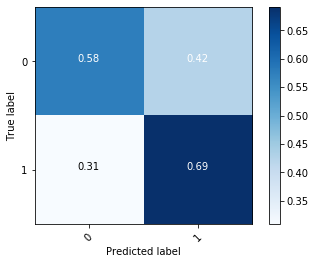

In [27]:
# Plot a normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True)

In [28]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
preds = gbc.predict(X_test)

print(f'Gradient Boosting: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

Gradient Boosting: 0.6451823302697896
AUC: 0.640436761684003
Precision: 0.6275766016713092
Recall: 0.7740494732020156
F1 Score: 0.6931596759306738


In [29]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[4122 4011]
 [1973 6759]]


Normalized confusion matrix
[[0.50682405 0.49317595]
 [0.22595053 0.77404947]]


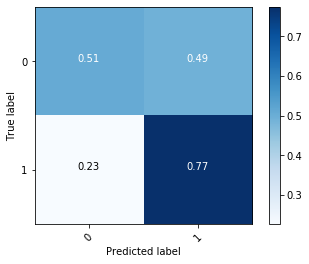

In [30]:
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True)

In [31]:
xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)

print(f'XGB Classifier: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

XGB Classifier: 0.6633857100504003
AUC: 0.659462308058892
Precision: 0.6470022134539505
Recall: 0.7699267063673844
F1 Score: 0.7031323537101919


In [32]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[4465 3668]
 [2009 6723]]


Normalized confusion matrix
[[0.54899791 0.45100209]
 [0.23007329 0.76992671]]


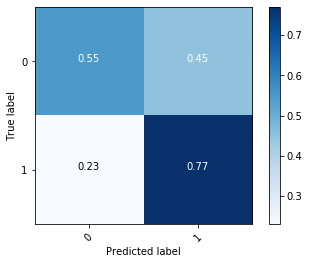

In [33]:
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
dt_param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [ ]:
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(xgb, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train, y_train)

In [34]:
# FEATURE IMPORTANCE
print (xgb.feature_importances_)

[0.00781241 0.00235717 0.0082031  0.00375032 0.0018037  0.
 0.00391149 0.01250393 0.00263683 0.00490163 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.03942924 0.00749536 0.00378498 0.00636595 0.00889711 0.01166571
 0.0065333  0.00598235 0.01693166 0.05300302 0.00543391 0.02406298
 0.00596509 0.00611061 0.0069169  0.00518953 0.0119246  0.01921945
 0.02298206 0.01224466 0.01491479 0.0115821  0.08849835 0.09448668
 0.00813726 0.01574265 0.00775445 0.0524409  0.01146029 0.02776271
 0.00624188 0.0030621  0.01347197 0.02772246 0.01268279 0.0050245
 0.0073184  0.0206777  0.01883158 0.0070806  0.01352299 0.01575575
 0.00909374 0.00423528 0.00609742 0.01967362 0.03718853 0.00610919
 0.00574123 0.01131625 0.00634206 0.01098412 0.01098009 0.00453524
 0.00753659 0.00323164 0.03368236 0.         0.00485548 0.
 0.         0.00437825 0.00182699]


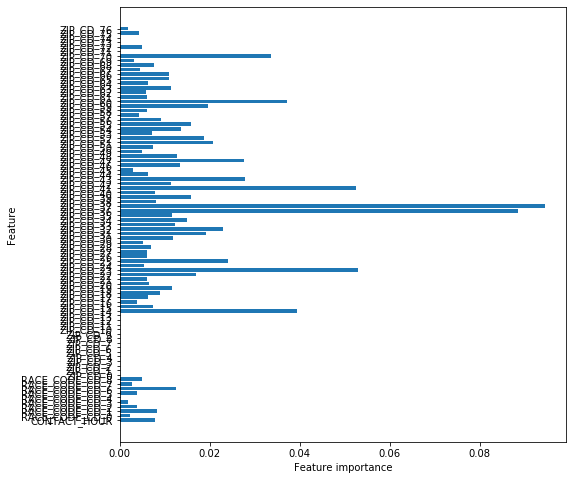

In [35]:
def plot_feature_importances(model):
    """Plots the importance of features from the model specified. Results are sorted by index."""
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(xgb)

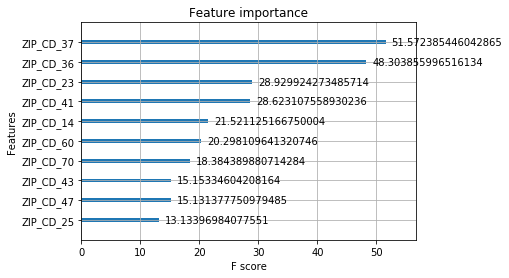

In [36]:
plot_importance(xgb,importance_type='gain', max_num_features=10)
pyplot.show()

In [ ]:
# figure out what these zips are, tie back in to Chicago demographics

In [ ]:
# EDA related to findings

# map those two zips arrest count vs all others
# percent of arrests in those two zips
# etc etc

In [ ]:
# PERCENT OF ARRESTS BY UNIT NUMBER
# ARRESTS BY OFFICER ID
# PERCENT OF RACE ARRESTS BY OFFICER
# ZIP CODES WITH HIGHEST NUMBER OF ARRESTS

In [37]:
df_clean.head()

,CONTACT_CARD_ID,CONTACT_TYPE_CD,CARD_NO,CONTACT_DATE,CONTACT_HOUR,SUBMITTING_BEAT_CD,JUVENILE_I,CLOTHING_DESCR,NAME_VERIFIED_I,RD_NO,...,STOLEN_PROPERTY_I,SEARCH_PROPERTY_I,S_ALCOHOL_I,S_PARA_I,S_STOLEN_PROPERTY_I,GANG_OTHER,OTHER_DESCR,S_OTHER_I,S_OTHER_DESCR,NAME
0,20410357,INVSTG,ISR000410357,01-JAN-2018 00:08,0,2523,N,"BROWN JACKET, JEANS",NaN,JB100012,...,NaN,N,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN
1,20410350,INVSTG,ISR000410350,01-JAN-2018 00:08,0,2523,N,BLUE JEANS AND A BLACK SWEATER,NaN,JB100012,...,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20410351,INVSTG,ISR000410351,01-JAN-2018 00:08,0,2523,N,"GRAY HOODED SWEATER, JEANS",NaN,JB100012,...,NaN,N,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN
3,20410338,INVSTG,ISR000410338,01-JAN-2018 00:10,0,6738,N,"BLACK LONGSLEEVE SHIRT, GREY JEANS",Y,NaN,...,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ORCHESTRA ALBANY
4,20410352,INVSTG,ISR000410352,01-JAN-2018 00:30,0,0767,N,"WHITE SOX HAT, BLACK JACKET, BLACK JEANS",Y,NaN,...,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# PERCENT OF ARRESTS BY UNIT NUMBER
# get binary to represent arrest

arrest_count = df_clean[['ENFORCEMENT_TYPE_CD', 'SUBMITTING_UNIT', 'SUBMITTING_BEAT_CD', 'CPD_UNIT_NO', 'CREATED_BY', 'RACE_CODE_CD', 'FO_EMPLOYEE_ID', 'SO_EMPLOYEE_ID', 'SUPV_EMPLOYEE_ID']]

In [39]:
arrest_count['TARGET'] = np.where(arrest_count['ENFORCEMENT_TYPE_CD'] == 'ARR', 1, 0)
arrest_count.head(20)

/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ENFORCEMENT_TYPE_CD,SUBMITTING_UNIT,SUBMITTING_BEAT_CD,CPD_UNIT_NO,CREATED_BY,RACE_CODE_CD,FO_EMPLOYEE_ID,SO_EMPLOYEE_ID,SUPV_EMPLOYEE_ID,TARGET
0,NaN,25,2523,25,185285,WWH,185285,845723.0,184324.0,0
1,NaN,25,2523,25,675642,WWH,675642,845723.0,184324.0,0
2,NaN,25,2523,25,185285,WWH,185285,845723.0,184324.0,0
3,NaN,313,6738,313,469481,WWH,469481,767063.0,225434.0,0
4,NaN,7,0767,7,666758,BLK,666758,816630.0,517843.0,0
5,NaN,7,0767,7,666758,BLK,666758,816630.0,517843.0,0
6,NaN,7,0767,7,666758,BLK,666758,816630.0,517843.0,0
7,NaN,7,0767,7,666758,BLK,666758,816630.0,517843.0,0
8,ARR,14,1461,14,555358,BLK,555358,614048.0,621961.0,1
9,ARR,14,1461,14,555358,BLK,555358,614048.0,621961.0,1


In [40]:
# remove lines missing SO_EMPLOYEE_ID
arrest_count.dropna(subset = ["SO_EMPLOYEE_ID"], axis=0, inplace=True)
arrest_count.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243702 entries, 0 to 290144
Data columns (total 10 columns):
ENFORCEMENT_TYPE_CD    54485 non-null object
SUBMITTING_UNIT        243702 non-null int64
SUBMITTING_BEAT_CD     243702 non-null object
CPD_UNIT_NO            243702 non-null int64
CREATED_BY             243702 non-null int64
RACE_CODE_CD           243702 non-null object
FO_EMPLOYEE_ID         243702 non-null int64
SO_EMPLOYEE_ID         243702 non-null float64
SUPV_EMPLOYEE_ID       243628 non-null float64
TARGET                 243702 non-null int64
dtypes: float64(2), int64(5), object(3)
memory usage: 20.5+ MB


/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
# remove lines missing SUPV_EMPLOYEE_ID
arrest_count.dropna(subset = ["SUPV_EMPLOYEE_ID"], axis=0, inplace=True)
arrest_count.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243628 entries, 0 to 290144
Data columns (total 10 columns):
ENFORCEMENT_TYPE_CD    54463 non-null object
SUBMITTING_UNIT        243628 non-null int64
SUBMITTING_BEAT_CD     243628 non-null object
CPD_UNIT_NO            243628 non-null int64
CREATED_BY             243628 non-null int64
RACE_CODE_CD           243628 non-null object
FO_EMPLOYEE_ID         243628 non-null int64
SO_EMPLOYEE_ID         243628 non-null float64
SUPV_EMPLOYEE_ID       243628 non-null float64
TARGET                 243628 non-null int64
dtypes: float64(2), int64(5), object(3)
memory usage: 20.4+ MB


/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [42]:
#  drop enforcement type, since it informs target

arrest_count.drop(columns = ["ENFORCEMENT_TYPE_CD"], axis=0, inplace=True)
arrest_count.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243628 entries, 0 to 290144
Data columns (total 9 columns):
SUBMITTING_UNIT       243628 non-null int64
SUBMITTING_BEAT_CD    243628 non-null object
CPD_UNIT_NO           243628 non-null int64
CREATED_BY            243628 non-null int64
RACE_CODE_CD          243628 non-null object
FO_EMPLOYEE_ID        243628 non-null int64
SO_EMPLOYEE_ID        243628 non-null float64
SUPV_EMPLOYEE_ID      243628 non-null float64
TARGET                243628 non-null int64
dtypes: float64(2), int64(5), object(2)
memory usage: 18.6+ MB


/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [43]:
# EDA before we move on to the model

In [ ]:
#arrest_count.groupby(["RACE_CODE_CD","FO_EMPLOYEE_ID"]).size().unstack().plot(kind='bar', stacked=True, figsize=(12,6),fontsize=14) 

In [44]:
arrest_count['FO_EMPLOYEE_ID'].nunique()

7101

In [45]:
# percentage of arrests - entire dataset

baseline_arrests = arrest_count[('TARGET')].value_counts(normalize=True) * 100
baseline_arrests

0    88.376952
1    11.623048
Name: TARGET, dtype: float64

In [47]:
first_emp_arrests = arrest_count.groupby('FO_EMPLOYEE_ID', as_index=False)['TARGET'].mean()
first_emp_arrests.sort_values(by='TARGET', ascending=False).head(10)

# interesting - some officers have 100% arrest rates
# they might only have one or two rows in this dataset
# let's limit this to officers that have 20 or more rows

,FO_EMPLOYEE_ID,TARGET
5955,831547,1.0
4267,608301,1.0
4238,604621,1.0
5638,791046,1.0
1153,165553,1.0
1786,253251,1.0
5155,726578,1.0
282,38836,1.0
3199,461201,1.0
3201,461308,1.0


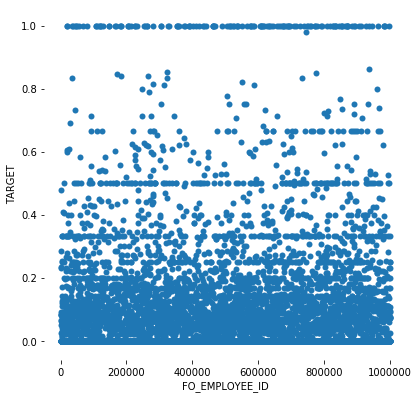

In [48]:
# scatterplot of employee arrest rates

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x='FO_EMPLOYEE_ID', y='TARGET',
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=first_emp_arrests, ax=ax)

In [50]:
# exclude any officers that have 20 or fewer arrests

filtered = arrest_count.groupby('FO_EMPLOYEE_ID').filter(lambda x: len(x) >= 21)
filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213478 entries, 0 to 290144
Data columns (total 9 columns):
SUBMITTING_UNIT       213478 non-null int64
SUBMITTING_BEAT_CD    213478 non-null object
CPD_UNIT_NO           213478 non-null int64
CREATED_BY            213478 non-null int64
RACE_CODE_CD          213478 non-null object
FO_EMPLOYEE_ID        213478 non-null int64
SO_EMPLOYEE_ID        213478 non-null float64
SUPV_EMPLOYEE_ID      213478 non-null float64
TARGET                213478 non-null int64
dtypes: float64(2), int64(5), object(2)
memory usage: 16.3+ MB


In [51]:
filt_first_emp = filtered.groupby('FO_EMPLOYEE_ID', as_index=False)['TARGET'].mean()
highest_20 = filt_first_emp.sort_values(by='TARGET', ascending=False).head(20)
highest_20

,FO_EMPLOYEE_ID,TARGET
694,262036,1.000000
2002,742961,0.980769
2500,936724,0.861111
857,321618,0.852459
450,172179,0.847458
477,182526,0.840580
702,264134,0.840000
1468,550037,0.822430
749,280368,0.815385
841,315172,0.811765


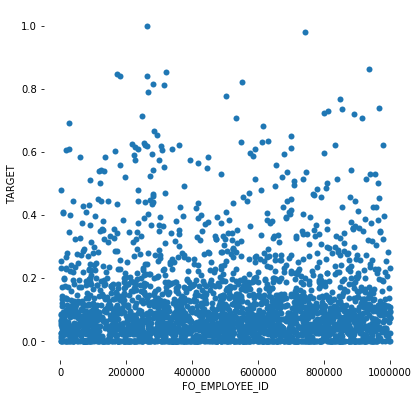

In [52]:
# here are all of the officers with more than 20 arrests

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x='FO_EMPLOYEE_ID', y='TARGET',
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=filt_first_emp, ax=ax)



In [ ]:
# let's repeat the same thing, but with supervisors

In [53]:
arrest_count['SUPV_EMPLOYEE_ID'].nunique()

1239

In [54]:
supv_arrests = arrest_count.groupby('SUPV_EMPLOYEE_ID', as_index=False)['TARGET'].mean()
supv_arrests.sort_values(by='TARGET', ascending=False).head(10)

,SUPV_EMPLOYEE_ID,TARGET
566,459073.0,1.0
766,616060.0,1.0
850,688690.0,1.0
274,212562.0,1.0
531,422310.0,1.0
873,703148.0,1.0
59,46235.0,1.0
667,532982.0,1.0
365,285934.0,1.0
815,651965.0,1.0


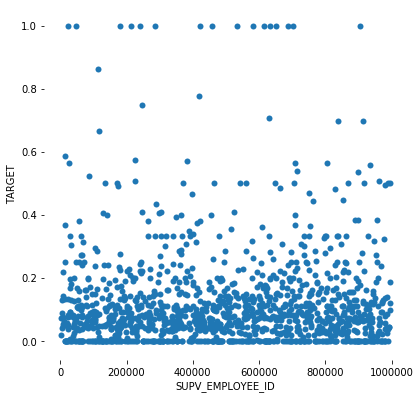

In [56]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x='SUPV_EMPLOYEE_ID', y='TARGET',
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=supv_arrests, ax=ax)

In [59]:
filtered_supv = arrest_count.groupby('SUPV_EMPLOYEE_ID').filter(lambda x: len(x) >= 21)
filtered_supv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240822 entries, 0 to 290144
Data columns (total 9 columns):
SUBMITTING_UNIT       240822 non-null int64
SUBMITTING_BEAT_CD    240822 non-null object
CPD_UNIT_NO           240822 non-null int64
CREATED_BY            240822 non-null int64
RACE_CODE_CD          240822 non-null object
FO_EMPLOYEE_ID        240822 non-null int64
SO_EMPLOYEE_ID        240822 non-null float64
SUPV_EMPLOYEE_ID      240822 non-null float64
TARGET                240822 non-null int64
dtypes: float64(2), int64(5), object(2)
memory usage: 18.4+ MB


In [60]:
filt_supv_arrests = filtered_supv.groupby('SUPV_EMPLOYEE_ID', as_index=False)['TARGET'].mean()
highest_20_supv = filt_supv_arrests.sort_values(by='TARGET', ascending=False).head(20)
highest_20_supv

,SUPV_EMPLOYEE_ID,TARGET
104,114341.0,0.860656
222,245635.0,0.748466
802,913839.0,0.698630
729,838875.0,0.697143
12,13429.0,0.587209
200,225434.0,0.574879
616,708954.0,0.565657
20,25330.0,0.565558
695,804918.0,0.563981
819,936333.0,0.557047


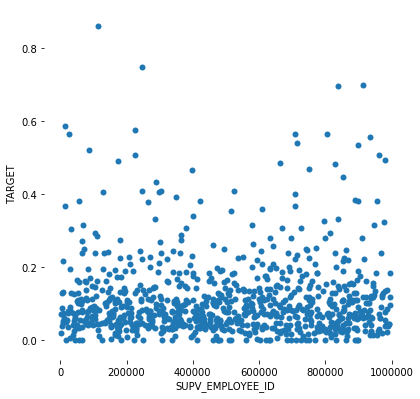

In [61]:
# here are all of the supervisors with more than 20 arrests

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x='SUPV_EMPLOYEE_ID', y='TARGET',
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=filt_supv_arrests, ax=ax)

In [ ]:
# list out 20 worst supervisors
# target is "worst" list
# based on 

In [ ]:
# NEXT STEPS

# number of rows by each officer, number of arrests
# number of rows by each supervisor, number of arrests

# for above info, keep race
# re-pull arrest count with "card" aka unique identifier
# remove duplicates